In [130]:
from typing import Any

import os
from os.path import join

from PIL import Image
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
from torch import Tensor
from torch import nn
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms

In [145]:
FACE_DIR = '../faces'
FILTERED_FACE_DIR = '../filtered_faces'
SAMPLE_FACE_DIR = '../sample_faces'

In [146]:
all_faces = os.listdir(FACE_DIR)
all_faces = [f'{FACE_DIR}/{face}' for face in all_faces]

sample_faces = os.listdir(SAMPLE_FACE_DIR)
all_faces = [f'{SAMPLE_FACE_DIR}/{face}' for face in all_faces]

In [148]:
class FaceDataset(Dataset):
    def __init__(self, dir, predict=False) -> None:
        super().__init__()
        self.transform = transforms.ToTensor()
        
        self.images = os.listdir(dir)
        self.images = [join(dir, img) for img in self.images]

        self.labels = [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
                       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1]
        self.labels = torch.tensor(self.labels, dtype=torch.float).unsqueeze(1)

        self.dir = dir
        self.predict = predict

    def __getitem__(self, index) -> Any:
        img = Image.open(self.images[index])
        if self.predict:
            return self.transform(img)
        else:
            return self.transform(img), self.labels[index]

    def __len__(self):
        return len(os.listdir(self.dir))

In [147]:
class FaceValidateV1(nn.Module):
    def __init__(self):
        super(FaceValidateV1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=0)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=4, padding=0)
        
        self.dropout1 = nn.Dropout2d(p=0.4)
        self.dropout2 = nn.Dropout2d(p=0.2)
        self.dropout3 = nn.Dropout2d(p=0.1)
        
        self.flatten = nn.Flatten()
        
        self.tanh1 = nn.Linear(in_features=8*8, out_features=64)
        self.tanh2 = nn.Linear(in_features=64, out_features=16)
        self.tanh3 = nn.Linear(in_features=16, out_features=1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.dropout1(x)

        x = torch.relu(self.conv2(x))
        x = self.dropout2(x)

        x = torch.relu(self.conv3(x))
        x = self.dropout3(x)

        x = self.flatten(x)

        x = torch.tanh(self.tanh1(x))
        x = torch.tanh(self.tanh2(x))
        x = torch.tanh(self.tanh3(x))

        x = self.sigmoid(x)
        
        return x

In [160]:
# Define constants
LEARNING_RATE = 0.0001
BATCH_SIZE = 16
NUM_EPOCHS = 200

dataset = FaceDataset('../sample_faces')
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Create model instance
model = FaceValidateV1()

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)  # L2 regularization

In [161]:
# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0.0
    
    for batch, labels in dataloader:
        images = batch
        # labels = torch.ones(images.size(0), 4)  # Assuming each image has 4 label values

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # L2 regularization term
        l2_reg = sum(torch.norm(param) for param in model.parameters())
        loss += 0.001 * l2_reg
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Avg Loss: {avg_loss:.4f}")

print("Training complete.")

Epoch [1/200] - Avg Loss: 0.7135
Epoch [2/200] - Avg Loss: 0.7132
Epoch [3/200] - Avg Loss: 0.7119
Epoch [4/200] - Avg Loss: 0.7126
Epoch [5/200] - Avg Loss: 0.7099
Epoch [6/200] - Avg Loss: 0.7112
Epoch [7/200] - Avg Loss: 0.7091
Epoch [8/200] - Avg Loss: 0.7049
Epoch [9/200] - Avg Loss: 0.7066
Epoch [10/200] - Avg Loss: 0.7068
Epoch [11/200] - Avg Loss: 0.7000
Epoch [12/200] - Avg Loss: 0.6980
Epoch [13/200] - Avg Loss: 0.6969
Epoch [14/200] - Avg Loss: 0.6910
Epoch [15/200] - Avg Loss: 0.6845
Epoch [16/200] - Avg Loss: 0.6731
Epoch [17/200] - Avg Loss: 0.6762
Epoch [18/200] - Avg Loss: 0.6723
Epoch [19/200] - Avg Loss: 0.6559
Epoch [20/200] - Avg Loss: 0.6498
Epoch [21/200] - Avg Loss: 0.6282
Epoch [22/200] - Avg Loss: 0.6248
Epoch [23/200] - Avg Loss: 0.6207
Epoch [24/200] - Avg Loss: 0.6090
Epoch [25/200] - Avg Loss: 0.5886
Epoch [26/200] - Avg Loss: 0.5953
Epoch [27/200] - Avg Loss: 0.5864
Epoch [28/200] - Avg Loss: 0.5691
Epoch [29/200] - Avg Loss: 0.5824
Epoch [30/200] - Avg Lo

In [189]:
all_faces = os.listdir('../faces')
pred = []
with torch.no_grad():
    model.eval()

    for face in all_faces:
        file_path = '../faces/' + face
        
        transfom = transforms.ToTensor()
        
        img = Image.open(file_path)
        img = transfom(img)
        img = img.unsqueeze(0)

        y_pred = model(img).item()
        pred.append(y_pred)
pred = np.array(pred)

In [177]:
all_faces = np.where(pred < 0.7)
all_faces = np.array(all_faces).squeeze()

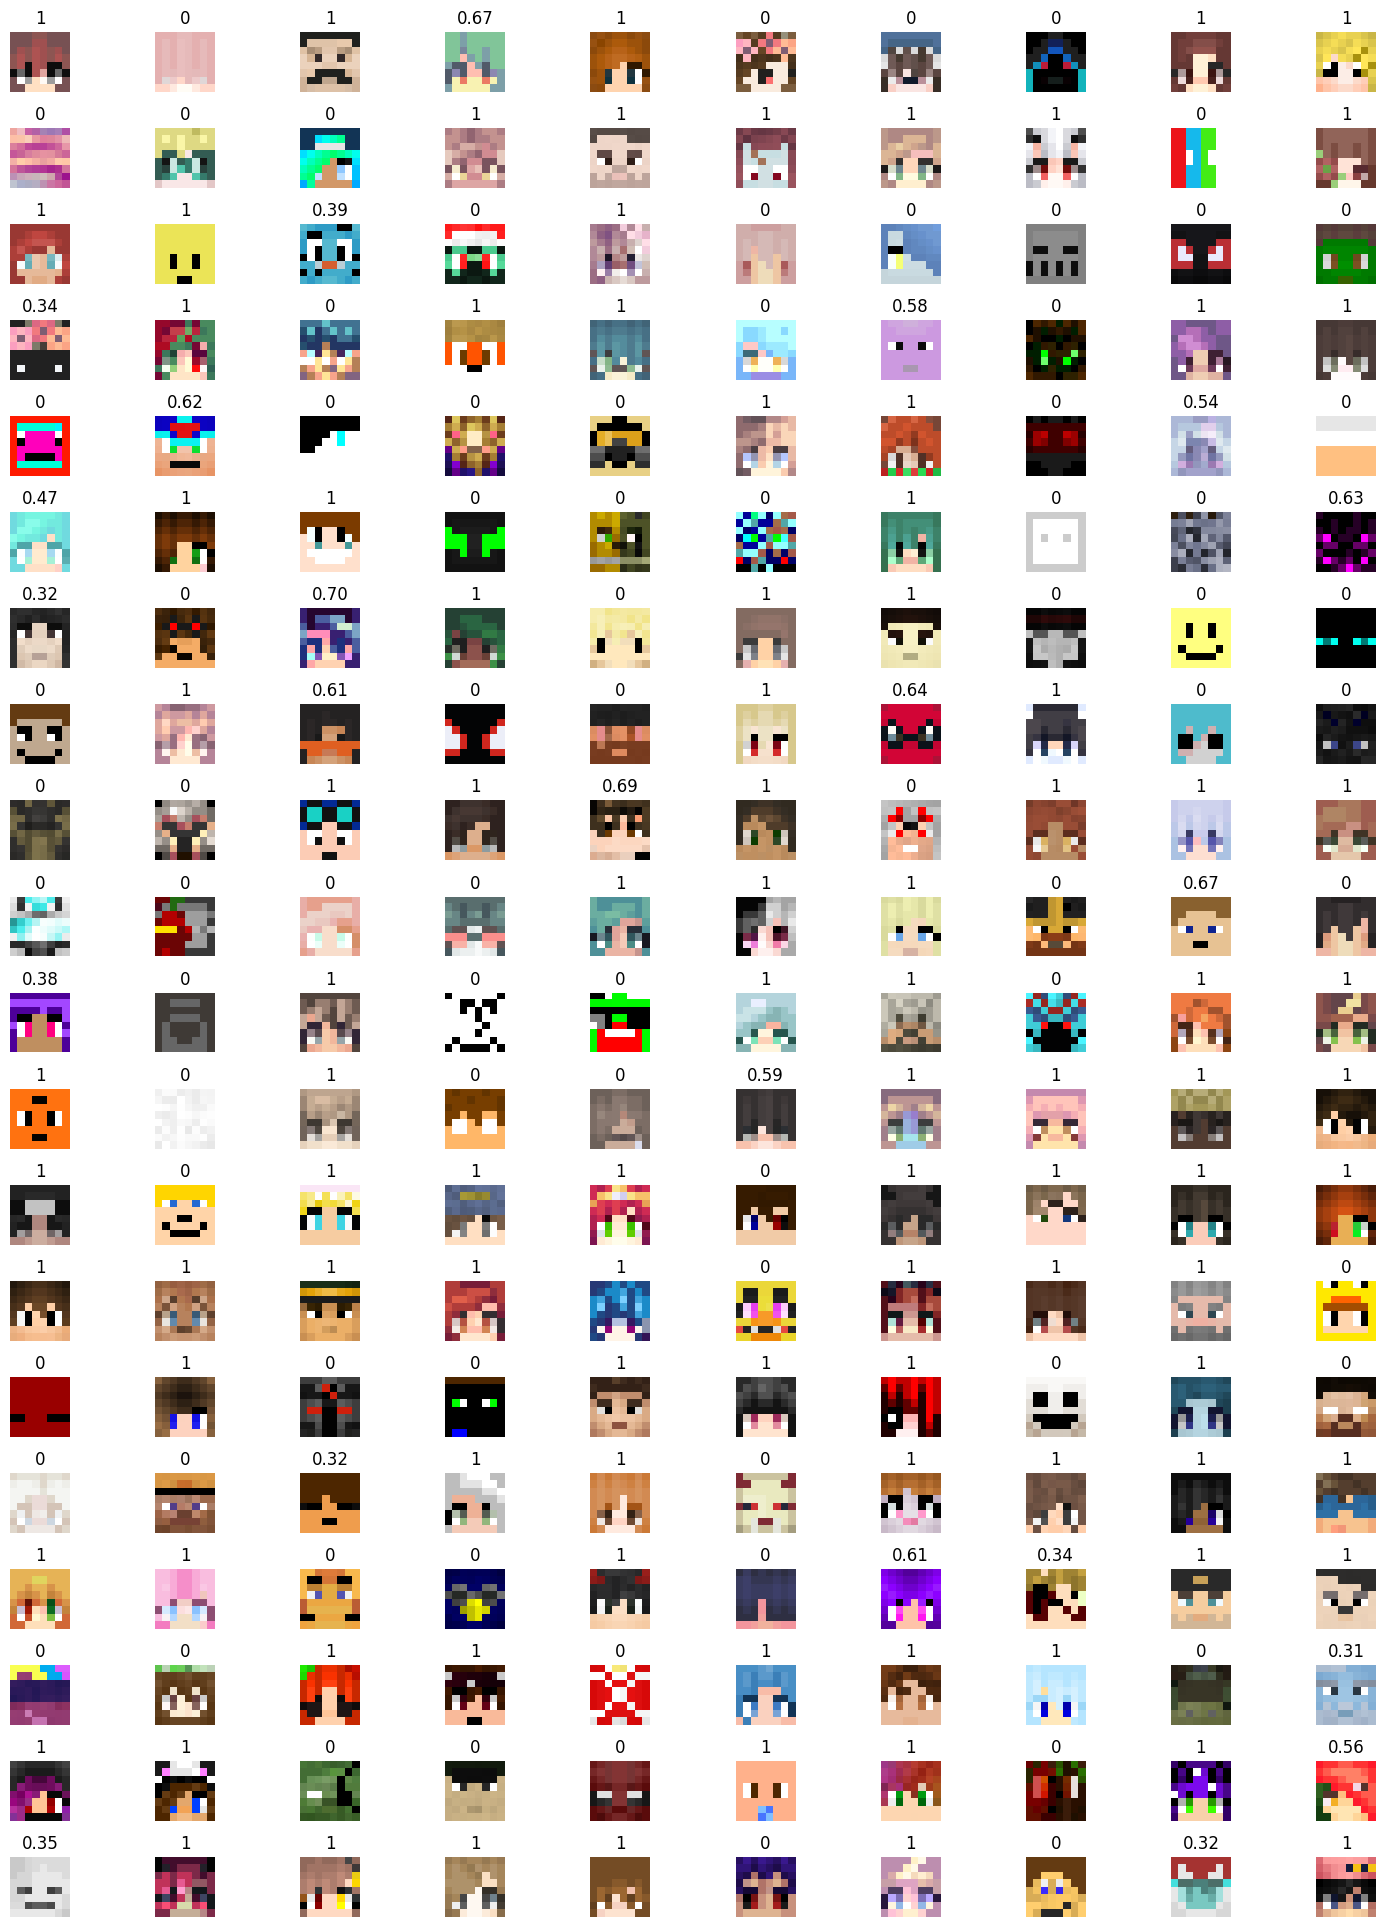

In [192]:
num_faces = 200

fig, axs = plt.subplots(num_faces // 10, 10, figsize=(15, 20))

for i, face_file in enumerate(all_faces[:200]):
    img = mpimg.imread(os.path.join('../faces', face_file))
    axs[i // 10, i % 10].imshow(img)
    axs[i // 10, i % 10].axis('off')
    if pred[i] > 0.7:
        title = '1'
    elif pred[i] < 0.3:
        title = '0'
    else:
        title = f'{pred[i]:.02f}'
    axs[i // 10, i % 10].set_title(title)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

In [195]:
import shutil

valid_index = 1
for i, face_file in enumerate(all_faces):
    if pred[i] > 0.7:
        shutil.copy(
            join(FACE_DIR, face_file),
            join('../valid_faces', f'{valid_index:05d}.png')
        )
        valid_index += 1